# IA classificadora de texto

## Parte 0: Instalação e inicialização dos pacotes necessários

In [2]:
%pip install spacy transformers

In [3]:
%pip install nltk pandas scikit-learn matplotlib seaborn

In [4]:
%pip install --upgrade pip

In [5]:
%pip install 'tensorflow[and-cuda]'

In [6]:
import warnings
warnings.filterwarnings('ignore')

import math
import spacy
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import transformers
from tokenizers import BertWordPieceTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow import keras
from keras.utils import to_categorical
from keras import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.metrics import Precision, Recall, AUC
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, LearningRateScheduler, CallbackList, ReduceLROnPlateau

In [7]:
%env TOKENIZERS_PARALLELISM=true

env: TOKENIZERS_PARALLELISM=true


In [8]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Modelo 1 - Fully connected neural network

### Parte 1.1: Pré-processamento de dados do input

In [9]:
data_train = pd.read_csv('dados_treino.txt', header=None, delimiter=';')
data_test = pd.read_csv('dados_teste.txt', header=None, delimiter=';')

In [10]:
data_train.rename(columns={0: 'text', 1: 'sentiment'}, inplace=True)
data_test.rename(columns={0: 'text', 1: 'sentiment'}, inplace=True)

In [11]:
print('shape train data: {}\nshape test data: {}'.format(data_train.shape, data_test.shape))

shape train data: (16000, 2)
shape test data: (2000, 2)


In [12]:
data_train.head()

,text,sentiment
0,i am feeling completely overwhelmed i have two...,fear
1,i have the feeling she was amused and delighted,joy
2,i was able to help chai lifeline with your sup...,joy
3,i already feel like i fucked up though because...,anger
4,i still love my so and wish the best for him i...,sadness


In [13]:
data_test.head()

,text,sentiment
0,i feel like my only role now would be to tear ...,sadness
1,i feel just bcoz a fight we get mad to each ot...,anger
2,i feel like reds and purples are just so rich ...,joy
3,im not sure the feeling of loss will ever go a...,sadness
4,i feel like ive gotten to know many of you thr...,joy


In [14]:
data_train['sentiment'].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: sentiment, dtype: int64

In [15]:
data_test['sentiment'].value_counts()

joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: sentiment, dtype: int64

In [16]:
!python -m spacy download en_core_web_md -q

2024-01-25 20:55:50.053166: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-25 20:55:50.053220: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-25 20:55:50.054503: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-25 20:55:51.117340: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 12.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [17]:
nlp = spacy.load('en_core_web_md')

In [18]:
def process_text(text: str) -> str:
    doc = nlp(text)
    tokens = [token.lemma_.lower().strip() for token in doc if not token.is_stop]
    return ' '.join(tokens)

In [19]:
data_train['processed_text'] = data_train['text'].apply(process_text)

In [20]:
data_train.head()

,text,sentiment,processed_text
0,i am feeling completely overwhelmed i have two...,fear,feel completely overwhelmed strategy help feel...
1,i have the feeling she was amused and delighted,joy,feeling amuse delight
2,i was able to help chai lifeline with your sup...,joy,able help chai lifeline support encouragement ...
3,i already feel like i fucked up though because...,anger,feel like fuck not usually eat morning
4,i still love my so and wish the best for him i...,sadness,love wish good long tolerate effect bm life fa...


In [21]:
data_test['processed_text'] = data_test['text'].apply(process_text)

In [22]:
data_test.head()

,text,sentiment,processed_text
0,i feel like my only role now would be to tear ...,sadness,feel like role tear sail pessimism discontent
1,i feel just bcoz a fight we get mad to each ot...,anger,feel bcoz fight mad n u wanna publicity n let ...
2,i feel like reds and purples are just so rich ...,joy,feel like red purple rich kind perfect
3,im not sure the feeling of loss will ever go a...,sadness,m sure feeling loss away dull sweet feeling no...
4,i feel like ive gotten to know many of you thr...,joy,feel like ve get know comment email m apprecia...


In [23]:
tf_idf = TfidfVectorizer(max_df = 0.95, min_df = 2, stop_words='english')

In [24]:
tfidf_train = tf_idf.fit_transform(data_train['processed_text'])
tfidf_test = tf_idf.transform(data_test['processed_text'])

In [25]:
print(f"shape training data: {tfidf_train.shape}\nshape test data: {tfidf_test.shape}")

shape training data: (16000, 5587)
shape test data: (2000, 5587)


In [26]:
X_train = tfidf_train.toarray()
X_test = tfidf_test.toarray()

### Parte 1.2: Pré-processamento dos dados de output

In [27]:
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(data_train['sentiment'])
y_test = label_encoder.transform(data_test['sentiment'])

In [28]:
weights = compute_class_weight('balanced', classes = np.unique(y_train), y = y_train)

type(weights)

numpy.ndarray

In [29]:
X_training, X_valid, y_training, y_valid = train_test_split(X_train,
                                                            y_train,
                                                            test_size = 0.2,
                                                            random_state = 42,
                                                            stratify=y_train)

y_training_encoded = to_categorical(y_training)
y_valid_encoded = to_categorical(y_valid)
y_test_encoded = to_categorical(y_test)


In [30]:
print(y_training, y_training_encoded)
type(y_training_encoded)

[4 2 2 ... 4 2 2] [[0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]


numpy.ndarray

### Parte 2: Criação do modelo

In [31]:
activation, initializer, input_shape, regularizer = 'selu', 'lecun_normal', (X_training.shape[1],), keras.regularizers.l2(0.01)
regularizer_2 = keras.regularizers.l2(0.1)

In [32]:
fcnn = Sequential([
    Dense(4096,
          activation=activation,
          kernel_initializer=initializer,
          input_shape=(input_shape),
          kernel_regularizer=regularizer
          ),
    Dense(2048,
          activation=activation,
          kernel_initializer=initializer,
          kernel_regularizer=regularizer
          ),
    Dense(1024,
          activation=activation,
          kernel_initializer=initializer,
          kernel_regularizer=regularizer_2
          ),
    Dense(64, activation=activation),
    Dense(6, activation='softmax')
])

In [33]:
fcnn.layers[-1].bias.assign(weights)

<tf.Variable 'UnreadVariable' shape=(6,) dtype=float32, numpy=
array([1.2351397 , 1.3766993 , 0.49732688, 2.0449898 , 0.5715102 ,
       4.6620045 ], dtype=float32)>

In [34]:
fcnn.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
fcnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              22888448  
                                                                 
 dense_1 (Dense)             (None, 2048)              8390656   
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_3 (Dense)             (None, 64)                65600     
                                                                 
 dense_4 (Dense)             (None, 6)                 390       
                                                                 
Total params: 33443270 (127.58 MB)
Trainable params: 33443270 (127.58 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
l_rate_0 = 0.001
drop = 0.5
epochs_drop = 10

lr_scheduler = LearningRateScheduler(lambda epoch: l_rate_0 * math.pow(drop, math.floor(((1+ epoch) / epochs_drop))))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [37]:
epochs = 20
batch_size = 256

In [38]:
%%time
history = fcnn.fit(X_training,
                   y_training_encoded,
                   epochs=epochs,
                   batch_size=batch_size,
                   validation_data=(X_valid, y_valid_encoded),
                   callbacks=[early_stopping, lr_scheduler]
                   )

Epoch 1/20
50/50 [==============================] - 5s 40ms/step - loss: 37.1753 - accuracy: 0.6441 - val_loss: 2.2798 - val_accuracy: 0.7738 - lr: 0.0010
Epoch 2/20
50/50 [==============================] - 1s 26ms/step - loss: 1.5078 - accuracy: 0.7889 - val_loss: 1.3666 - val_accuracy: 0.7738 - lr: 0.0010
Epoch 3/20
50/50 [==============================] - 1s 27ms/step - loss: 1.1992 - accuracy: 0.8121 - val_loss: 1.2112 - val_accuracy: 0.8031 - lr: 0.0010
Epoch 4/20
50/50 [==============================] - 1s 26ms/step - loss: 1.0573 - accuracy: 0.8430 - val_loss: 1.1217 - val_accuracy: 0.8166 - lr: 0.0010
Epoch 5/20
50/50 [==============================] - 1s 26ms/step - loss: 0.9451 - accuracy: 0.8698 - val_loss: 1.0731 - val_accuracy: 0.8209 - lr: 0.0010
Epoch 6/20
50/50 [==============================] - 1s 23ms/step - loss: 0.9018 - accuracy: 0.8876 - val_loss: 1.0868 - val_accuracy: 0.8269 - lr: 0.0010
Epoch 7/20
50/50 [==============================] - 1s 25ms/step - loss: 0.

### Parte 3: análise do desempenho do modelo

In [39]:
loss, val_loss = history.history['loss'], history.history['val_loss']

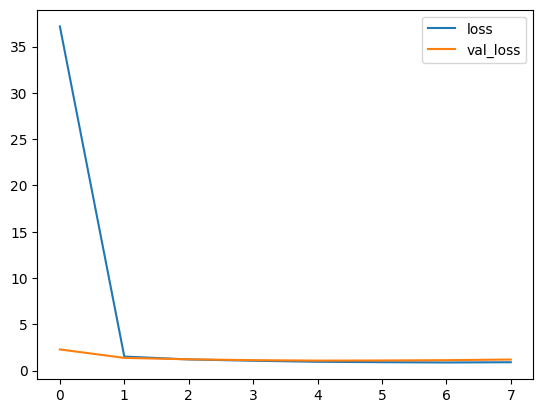

In [40]:
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.legend()
plt.show()

In [41]:
predict_v1 = fcnn.predict(X_test)

63/63 [==============================] - 0s 2ms/step


In [42]:
predict_v1.argmax(axis=1)

array([4, 0, 2, ..., 2, 2, 1])

In [43]:
report = classification_report(y_test, predict_v1.argmax(axis=1), output_dict=True)

In [44]:
pd.DataFrame(report).T

,precision,recall,f1-score,support
0,0.783688,0.803636,0.793537,275.0000
1,0.769231,0.848214,0.806794,224.0000
2,0.866295,0.894964,0.880396,695.0000
3,0.696552,0.635220,0.664474,159.0000
4,0.886525,0.860585,0.873362,581.0000
5,0.704545,0.469697,0.563636,66.0000
accuracy,0.832500,0.832500,0.832500,0.8325
macro avg,0.784473,0.752053,0.763700,2000.0000
weighted avg,0.831110,0.832500,0.830547,2000.0000


In [45]:
# fcnn.save('first_model_v1.keras')

In [46]:
frase = 'I am stronger than ever'

exemplo = pd.DataFrame({'text': [frase]})

exemplo['processed_text'] = exemplo['text'].apply(process_text)

exemplo_model = tf_idf.transform(exemplo['processed_text']).toarray()

exemplo_model

array([[0., 0., 0., ..., 0., 0., 0.]])

In [47]:
label_encoder.inverse_transform(fcnn.predict(exemplo_model).argmax(axis=1))

1/1 [==============================] - 0s 33ms/step


array(['joy'], dtype=object)

### Parte 4: Otimização da entrada de dados ao modelo

In [48]:
class Model:
    def __init__(self, preprocess, model, postprocess) -> None:
        self.preprocess = preprocess
        self.model = model
        self.postprocess = postprocess

    def predict(self, text: str) -> str:
        input = self.preprocess(text)
        output = self.model.predict(input)
        return self.postprocess(output)

    __call__ = predict

In [49]:
def preprocessing_v1(text: str) -> np.ndarray:
    tmp = text
    if isinstance(text, str):
        tmp = pd.DataFrame({'text': [text]})['text']
    tmp['processed_text'] = tmp.apply(process_text)
    input = tf_idf.transform(tmp['processed_text']).toarray()
    return input

def postprocessing_v1(output: np.ndarray) -> str:
    return label_encoder.inverse_transform(output.argmax(axis=1))[0]

model_v0 = Model(preprocessing_v1, fcnn, postprocessing_v1)
model_v0('I feel a little shaky')

1/1 [==============================] - 0s 17ms/step


'fear'

### Parte 5: Otimização do modelo

Opção 1: Modificando a função de ativação

In [50]:
activation = 'relu'

In [51]:
fcnn_v2 = Sequential([
    Dense(4096,
          activation=activation,
          kernel_initializer=initializer,
          input_shape=(input_shape),
          kernel_regularizer=regularizer
          ),
    Dense(2048,
          activation=activation,
          kernel_initializer=initializer,
          kernel_regularizer=regularizer
          ),
    Dense(1024,
          activation=activation,
          kernel_initializer=initializer,
          kernel_regularizer=regularizer_2
          ),
    Dense(64, activation=activation),
    Dense(6, activation='softmax')
])

fcnn_v2.layers[-1].bias.assign(weights)

fcnn_v2.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

fcnn_v2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 4096)              22888448  
                                                                 
 dense_6 (Dense)             (None, 2048)              8390656   
                                                                 
 dense_7 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_8 (Dense)             (None, 64)                65600     
                                                                 
 dense_9 (Dense)             (None, 6)                 390       
                                                                 
Total params: 33443270 (127.58 MB)
Trainable params: 33443270 (127.58 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
history2 = fcnn_v2.fit(X_training,
            y_training_encoded,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_valid, y_valid_encoded),
            callbacks=[early_stopping, lr_scheduler]
            )

Epoch 1/20
50/50 [==============================] - 4s 38ms/step - loss: 36.6136 - accuracy: 0.2798 - val_loss: 2.4620 - val_accuracy: 0.3350 - lr: 0.0010
Epoch 2/20
50/50 [==============================] - 1s 26ms/step - loss: 1.7741 - accuracy: 0.3285 - val_loss: 1.6098 - val_accuracy: 0.3000 - lr: 0.0010
Epoch 3/20
50/50 [==============================] - 1s 26ms/step - loss: 1.5959 - accuracy: 0.3349 - val_loss: 1.5825 - val_accuracy: 0.3350 - lr: 0.0010
Epoch 4/20
50/50 [==============================] - 1s 27ms/step - loss: 1.5807 - accuracy: 0.3352 - val_loss: 1.5779 - val_accuracy: 0.3350 - lr: 0.0010
Epoch 5/20
50/50 [==============================] - 1s 23ms/step - loss: 1.5772 - accuracy: 0.3288 - val_loss: 1.5795 - val_accuracy: 0.3350 - lr: 0.0010
Epoch 6/20
50/50 [==============================] - 1s 26ms/step - loss: 1.5782 - accuracy: 0.3300 - val_loss: 1.5777 - val_accuracy: 0.3350 - lr: 0.0010
Epoch 7/20
50/50 [==============================] - 1s 26ms/step - loss: 1.

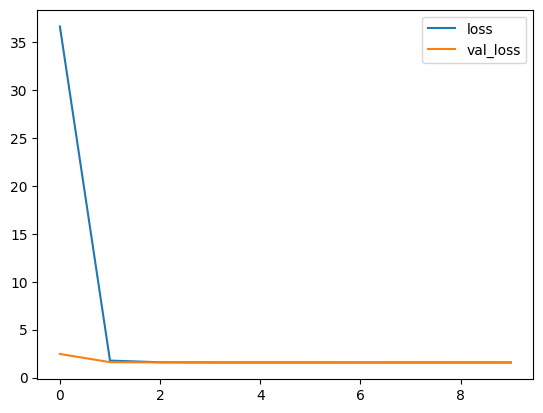

In [53]:
loss2, val_loss2 = history2.history['loss'], history2.history['val_loss']

plt.plot(loss2, label='loss')
plt.plot(val_loss2, label='val_loss')
plt.legend()
plt.show()

Testando mudança no número de neurônios

In [54]:
activation = 'selu'

fcnn_v3 = Sequential([
    Dense(4096,
          activation=activation,
          kernel_initializer=initializer,
          input_shape=(input_shape),
          kernel_regularizer=regularizer
          ),
    Dense(4096,
          activation=activation,
          kernel_initializer=initializer,
          kernel_regularizer=regularizer
          ),
    Dense(2048,
          activation=activation,
          kernel_initializer=initializer,
          kernel_regularizer=regularizer
          ),
    Dense(1024,
          activation=activation,
          kernel_initializer=initializer,
          kernel_regularizer=regularizer_2
          ),
    Dense(64, activation=activation),
    Dense(6, activation='softmax')
])

fcnn_v3.layers[-1].bias.assign(weights)

fcnn_v3.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

fcnn_v3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 4096)              22888448  
                                                                 
 dense_11 (Dense)            (None, 4096)              16781312  
                                                                 
 dense_12 (Dense)            (None, 2048)              8390656   
                                                                 
 dense_13 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_14 (Dense)            (None, 64)                65600     
                                                                 
 dense_15 (Dense)            (None, 6)                 390       
                                                                 
Total params: 50224582 (191.59 MB)
Trainable params: 5

In [55]:
history3 = fcnn_v3.fit(X_training,
                       y_training_encoded,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=(X_valid, y_valid_encoded),
                       callbacks=[early_stopping, lr_scheduler]
                       )

Epoch 1/20
50/50 [==============================] - 5s 55ms/step - loss: 48.7924 - accuracy: 0.6773 - val_loss: 2.7333 - val_accuracy: 0.7991 - lr: 0.0010
Epoch 2/20
50/50 [==============================] - 2s 39ms/step - loss: 1.6474 - accuracy: 0.8082 - val_loss: 1.4314 - val_accuracy: 0.8044 - lr: 0.0010
Epoch 3/20
50/50 [==============================] - 2s 39ms/step - loss: 1.2376 - accuracy: 0.8374 - val_loss: 1.2819 - val_accuracy: 0.8166 - lr: 0.0010
Epoch 4/20
50/50 [==============================] - 2s 40ms/step - loss: 1.1328 - accuracy: 0.8616 - val_loss: 1.2678 - val_accuracy: 0.8081 - lr: 0.0010
Epoch 5/20
50/50 [==============================] - 2s 39ms/step - loss: 1.0015 - accuracy: 0.8895 - val_loss: 1.1399 - val_accuracy: 0.8353 - lr: 0.0010
Epoch 6/20
50/50 [==============================] - 2s 38ms/step - loss: 0.9332 - accuracy: 0.9073 - val_loss: 1.1831 - val_accuracy: 0.8328 - lr: 0.0010
Epoch 7/20
50/50 [==============================] - 2s 36ms/step - loss: 0.

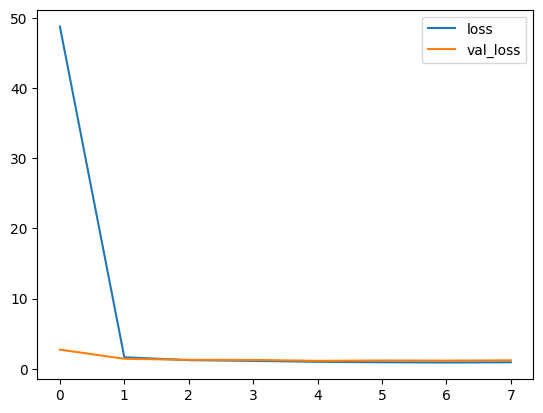

In [56]:
loss3, val_loss3 = history3.history['loss'], history3.history['val_loss']

plt.plot(loss3, label='loss')
plt.plot(val_loss3, label='val_loss')
plt.legend()
plt.show()

Testando mudar a paciência do EarlyStopping

In [57]:
new_early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

fcnn_v4 = Sequential([
    Dense(4096,
          activation=activation,
          kernel_initializer=initializer,
          input_shape=(input_shape),
          kernel_regularizer=regularizer
          ),
    Dense(2048,
          activation=activation,
          kernel_initializer=initializer,
          kernel_regularizer=regularizer
          ),
    Dense(1024,
          activation=activation,
          kernel_initializer=initializer,
          kernel_regularizer=regularizer_2
          ),
    Dense(64, activation=activation),
    Dense(6, activation='softmax')
])

fcnn_v4.layers[-1].bias.assign(weights)
fcnn_v4.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
fcnn_v4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 4096)              22888448  
                                                                 
 dense_17 (Dense)            (None, 2048)              8390656   
                                                                 
 dense_18 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_19 (Dense)            (None, 64)                65600     
                                                                 
 dense_20 (Dense)            (None, 6)                 390       
                                                                 
Total params: 33443270 (127.58 MB)
Trainable params: 33443270 (127.58 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [58]:
history4 = fcnn_v4.fit(X_training,
                       y_training_encoded,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=(X_valid, y_valid_encoded),
                       callbacks=[new_early_stopping, lr_scheduler]
                       )

Epoch 1/20
50/50 [==============================] - 4s 44ms/step - loss: 36.9412 - accuracy: 0.6793 - val_loss: 2.2503 - val_accuracy: 0.7975 - lr: 0.0010
Epoch 2/20
50/50 [==============================] - 1s 27ms/step - loss: 1.4800 - accuracy: 0.7995 - val_loss: 1.3105 - val_accuracy: 0.7987 - lr: 0.0010
Epoch 3/20
50/50 [==============================] - 1s 27ms/step - loss: 1.1770 - accuracy: 0.8289 - val_loss: 1.2098 - val_accuracy: 0.8091 - lr: 0.0010
Epoch 4/20
50/50 [==============================] - 1s 28ms/step - loss: 1.0469 - accuracy: 0.8544 - val_loss: 1.1442 - val_accuracy: 0.8138 - lr: 0.0010
Epoch 5/20
50/50 [==============================] - 1s 29ms/step - loss: 0.9657 - accuracy: 0.8748 - val_loss: 1.0819 - val_accuracy: 0.8416 - lr: 0.0010
Epoch 6/20
50/50 [==============================] - 1s 25ms/step - loss: 0.8998 - accuracy: 0.8930 - val_loss: 1.1046 - val_accuracy: 0.8372 - lr: 0.0010
Epoch 7/20
50/50 [==============================] - 1s 27ms/step - loss: 0.

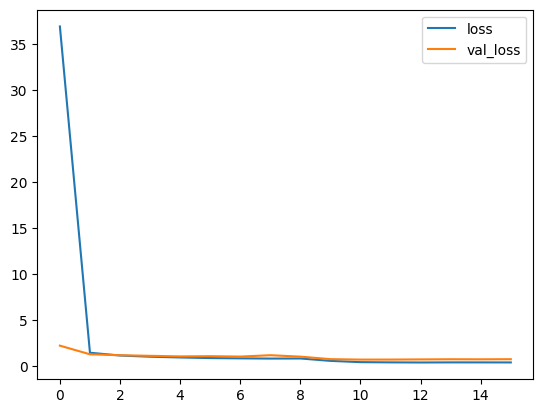

In [59]:
loss4, val_loss4 = history4.history['loss'], history4.history['val_loss']

plt.plot(loss4, label='loss')
plt.plot(val_loss4, label='val_loss')
plt.legend()
plt.show()


## Modelo 2: LSTM

### Parte 1.1: Pré-processamento da entrada

In [60]:
data_train.head()

,text,sentiment,processed_text
0,i am feeling completely overwhelmed i have two...,fear,feel completely overwhelmed strategy help feel...
1,i have the feeling she was amused and delighted,joy,feeling amuse delight
2,i was able to help chai lifeline with your sup...,joy,able help chai lifeline support encouragement ...
3,i already feel like i fucked up though because...,anger,feel like fuck not usually eat morning
4,i still love my so and wish the best for him i...,sadness,love wish good long tolerate effect bm life fa...


In [61]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(data_train['processed_text'])


In [62]:
sequence_train = tokenizer.texts_to_sequences(data_train['processed_text'])

In [63]:
max_length = 100
padded_sequence_train = pad_sequences(sequence_train, truncating='post', maxlen=max_length)
type(padded_sequence_train)

numpy.ndarray

In [64]:
def preprocessing_v2(text: str | pd.DataFrame, max_length: int = max_length, tokenizer: Tokenizer = tokenizer) -> np.ndarray:
    tmp = text
    if isinstance(text, str):
        tmp = pd.DataFrame({'text': [text]})['text']
    tmp['processed_text'] = tmp.apply(process_text)
    input = tokenizer.texts_to_sequences(tmp['processed_text'])
    final_input = pad_sequences(input, truncating='post', maxlen=max_length)
    return final_input

### Parte 1.2: Pré-processamento da saída

In [65]:
label_encoder_v2 = LabelEncoder()

y_train_v2 = label_encoder_v2.fit_transform(data_train['sentiment'])
y_test_v2 = label_encoder_v2.transform(data_test['sentiment'])

In [66]:
y_train_v2_encoded = to_categorical(y_train_v2)
y_test_v2_encoded = to_categorical(y_test_v2)

In [67]:
def postprocessing_v2(output: np.ndarray) -> str:
    return label_encoder_v2.inverse_transform(output.argmax(axis=1))[0]

In [68]:
vocab_size = len(tokenizer.word_index) + 1
embed_len = max_length
regularizer = 'l1_l2'
activation = 'leaky_relu'

In [69]:
lstm = Sequential([
    Embedding(vocab_size, embed_len, input_length=max_length),
    Bidirectional(LSTM(64)),
    Dropout(0.4),
    Dense(32, activation=activation, kernel_regularizer=regularizer),
    Dropout(0.4),
    Dense(6, activation='softmax')
])

In [70]:
lstm.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])
lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1189800   
                                                                 
 bidirectional (Bidirection  (None, 128)               84480     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_21 (Dense)            (None, 32)                4128      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_22 (Dense)            (None, 6)                 198       
                                                      

In [71]:
early_stopping_v1 = EarlyStopping(patience=5)
epochs = 35
validation_split = 0.2

In [72]:
history_v1 = lstm.fit(padded_sequence_train,
                      y_train_v2_encoded,
                      epochs=epochs,
                      validation_split=validation_split,
                      callbacks=[early_stopping_v1]
                      )

Epoch 1/35
400/400 [==============================] - 29s 54ms/step - loss: 2.4211 - accuracy: 0.3377 - precision: 0.7037 - recall: 0.0030 - auc: 0.7056 - val_loss: 1.5337 - val_accuracy: 0.4872 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7884
Epoch 2/35
400/400 [==============================] - 7s 17ms/step - loss: 1.1254 - accuracy: 0.6356 - precision: 0.8641 - recall: 0.4561 - auc: 0.9092 - val_loss: 0.8392 - val_accuracy: 0.7563 - val_precision: 0.8996 - val_recall: 0.5684 - val_auc: 0.9580
Epoch 3/35
400/400 [==============================] - 6s 15ms/step - loss: 0.7487 - accuracy: 0.7877 - precision: 0.8978 - recall: 0.6516 - auc: 0.9696 - val_loss: 0.7309 - val_accuracy: 0.7975 - val_precision: 0.8907 - val_recall: 0.6800 - val_auc: 0.9695
Epoch 4/35
400/400 [==============================] - 6s 15ms/step - loss: 0.6093 - accuracy: 0.8577 - precision: 0.9147 - recall: 0.7753 - auc: 0.9829 - val_loss: 0.6412 - val_accuracy: 0.8469 - val_precision: 0.8854 - 

In [73]:
model_v2 = Model(preprocessing_v2, lstm, postprocessing_v2)

In [74]:
model_v2('I am feeling a little bit happy')

1/1 [==============================] - 1s 928ms/step


'joy'

In [75]:
X_test_v2 = tokenizer.texts_to_sequences(data_test['processed_text'])
X_test_v2 = pad_sequences(X_test_v2, truncating='post', maxlen=max_length)
X_test_v2

array([[   0,    0,    0, ...,  506, 5699,  569],
       [   0,    0,    0, ...,   60,    6,  695],
       [   0,    0,    0, ...,  312,   50,  206],
       ...,
       [   0,    0,    0, ...,  132,    5, 2498],
       [   0,    0,    0, ...,   26,  488, 1785],
       [   0,    0,    0, ...,  122,  122, 1643]], dtype=int32)

In [76]:
predict_v2 = lstm.predict(X_test_v2)
print(classification_report(y_test_v2, predict_v2.argmax(axis=1)))

63/63 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       275
           1       0.84      0.89      0.87       224
           2       0.89      0.91      0.90       695
           3       0.71      0.70      0.70       159
           4       0.92      0.92      0.92       581
           5       0.80      0.61      0.69        66

    accuracy                           0.88      2000
   macro avg       0.84      0.82      0.83      2000
weighted avg       0.88      0.88      0.88      2000



In [77]:
confusion_matrix(y_test_v2, predict_v2.argmax(axis=1))

array([[237,  11,   5,   3,  19,   0],
       [  9, 200,   1,   2,   4,   8],
       [  1,   3, 634,  37,  19,   1],
       [  2,   2,  39, 111,   4,   1],
       [ 15,   7,  22,   1, 536,   0],
       [  0,  14,   9,   2,   1,  40]])

In [78]:
accuracy_score(y_test_v2, predict_v2.argmax(axis=1))

0.879

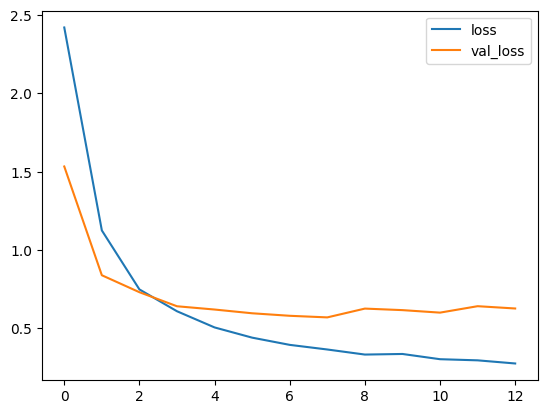

In [79]:
plt.plot(history_v1.history['loss'], label='loss')
plt.plot(history_v1.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [80]:
lstm.save('model_v2.keras')

## Part 3: BERT

In [81]:
def preprocessing_v3(text: str | pd.Series, tokenizer, max_length: int = max_length, batch_size: int = 256) -> np.ndarray:
    tmp = text
    if isinstance(text, str):
        tmp = pd.Series([text])
    tmp = tmp.apply(process_text)
    tokenizer.enable_truncation(max_length=max_length)
    tokenizer.enable_padding(length=max_length)
    ids = []
    for i in range(0, len(tmp), batch_size):
        ids.extend([enc.ids for enc in tokenizer.encode_batch(tmp[i:i+batch_size].tolist())])
    return np.array(ids)

In [82]:
bert_tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
bert_tokenizer.save_pretrained('.')
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False)
fast_tokenizer

Tokenizer(vocabulary_size=119547, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=False, wordpieces_prefix=##)

In [83]:
X_train_v3, X_valid_v3, y_train_v3, y_valid_v3 = train_test_split(data_train['processed_text'],
                                                                  data_train['sentiment'],
                                                                  stratify=data_train['sentiment'],
                                                                  test_size=0.2)
X_train_v3.head()

10302                         feel lose atom href http www
15336    tear feel stressed not tell show feel stressed...
14172    feel like delicate situation choice weekend po...
10534    feel groggy day race gland neck sore swollen t...
13597    feel like product support immune cardiovascula...
Name: processed_text, dtype: object

In [84]:
type(X_train_v3)

pandas.core.series.Series

In [85]:
final_X_train_v3, final_X_valid_v3 = preprocessing_v3(X_train_v3, fast_tokenizer), preprocessing_v3(X_valid_v3, fast_tokenizer)

In [86]:
final_X_test_v3 = preprocessing_v3(data_test['processed_text'], fast_tokenizer)

In [87]:
le = LabelEncoder()
final_y_train_v3 = le.fit_transform(y_train_v3)
final_y_valid_v3 = le.transform(y_valid_v3)
y_test_v3 = le.transform(data_test['sentiment'])

In [88]:
def postprocessing_v3(data):
    return le.inverse_transform(data.argmax(axis=1))[0]

In [89]:
final_y_train_v3_enc = to_categorical(final_y_train_v3)
final_y_valid_v3_enc = to_categorical(final_y_valid_v3)
final_y_test_v3_enc = to_categorical(y_test_v3)


In [90]:
BATCH_SIZE = 16

In [91]:
dataset_train = tf.data.Dataset.from_tensor_slices((final_X_train_v3, final_y_train_v3_enc)).repeat().shuffle(2048).batch(BATCH_SIZE)

In [92]:
dataset_valid = tf.data.Dataset.from_tensor_slices((final_X_valid_v3, final_y_valid_v3_enc)).batch(BATCH_SIZE).cache()

In [93]:
dataset_test = tf.data.Dataset.from_tensor_slices((final_X_test_v3, final_y_test_v3_enc)).batch(BATCH_SIZE)

In [94]:
def create_model(transformer, maxlen=max_length):
    input_word_ids = tf.keras.layers.Input(shape=(maxlen,), dtype=tf.int32, name='input_word_ids')
    seq_out = transformer(input_word_ids)[0]
    cls_token = seq_out[:,0,:]
    out = Dense(6, activation='softmax')(cls_token)
    model = tf.keras.Model(inputs=input_word_ids, outputs=out)
    model.compile(tf.keras.optimizers.legacy.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])
    return model

In [95]:
transformer_layer = transformers.TFDistilBertModel.from_pretrained('distilbert-base-multilingual-cased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [96]:
model = create_model(transformer_layer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer  [(None, 100)]             0         
 )                                                               
                                                                 
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_   134734080 
 stilBertModel)              hidden_state=(None, 100             
                             , 768),                             
                              hidden_states=None, at             
                             tentions=None)                      
                                                                 
 tf.__operators__.getitem (  (None, 768)               0         
 SlicingOpLambda)                                                
                                                                 
 dense_23 (Dense)            (None, 6)                 4614  

In [97]:
for i in range(3):
    model.layers[i].trainable = False
    print(model.layers[i].trainable)
model.summary()

False
False
False
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer  [(None, 100)]             0         
 )                                                               
                                                                 
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_   134734080 
 stilBertModel)              hidden_state=(None, 100             
                             , 768),                             
                              hidden_states=None, at             
                             tentions=None)                      
                                                                 
 tf.__operators__.getitem (  (None, 768)               0         
 SlicingOpLambda)                                                
                                                                 
 dense_23 (Dense)            (None, 6)     

In [98]:
n_steps = final_X_train_v3.shape[0]
n_epochs = 3

In [99]:
history_v3 = model.fit(dataset_train, steps_per_epoch=n_steps, validation_data=dataset_valid, epochs=n_epochs)

Epoch 1/3
 3074/12800 [======>.......................] - ETA: 33:29 - loss: 0.5194 - accuracy: 0.8015 - precision_1: 0.8959 - recall_1: 0.7365 - auc_1: 0.9725

KeyboardInterrupt: 

In [100]:
loss, val_loss = history_v3.history['loss'], history_v3.history['val_loss']
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.legend()
plt.show()

NameError: name 'history_v3' is not defined

In [101]:
previsoes = model.predict(final_X_test_v3)

63/63 [==============================] - 8s 105ms/step


In [102]:
labels_predicted = previsoes.argmax(axis=1)

In [105]:
print(classification_report(y_test_v3, labels_predicted))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       275
           1       0.86      0.88      0.87       224
           2       0.94      0.91      0.92       695
           3       0.77      0.80      0.78       159
           4       0.94      0.93      0.93       581
           5       0.64      0.89      0.75        66

    accuracy                           0.90      2000
   macro avg       0.84      0.88      0.86      2000
weighted avg       0.90      0.90      0.90      2000



In [106]:
model.save('transf.keras')